Import modulů

In [1153]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import eurostat

## Zvol ROK a STÁT

In [1154]:
YEAR = 2018 
STATE = 'SK'  

Popisky



In [1155]:
label_dict = {'CRF2':'Průmyslové procesy (výroba cementu, oceli,...)', 'CRF1A3|CRF1D1A':'Doprava (včetně letecké)','CRF1A2':'Spalování v průmyslu', 'CRF1A1':'Energetika','CRF1A4':'Spalování v domácnostech, institucích a zemědělství','CRF3':'Zemědělství','CRF5':'Odpadové hospodářství','TOTX4_MEMONIA':'jiné'}


Stáhni dataframe "env_air_gge"

In [1156]:
df = eurostat.get_data_df('env_air_gge')

In [1157]:
df.head(2) # s kým mám tu čest... 

,unit,airpol,src_crf,geo\time,2020,2019,2018,2017,2016,2015,...,1994,1993,1992,1991,1990,1989,1988,1987,1986,1985
0,MIO_T,CH4,CRF1,AT,0.02177,0.02223,0.02289,0.02578,0.02442,0.02428,...,0.03347,0.04038,0.04278,0.04369,0.04858,NaN,NaN,NaN,NaN,NaN
1,MIO_T,CH4,CRF1,BE,0.04085,0.04232,0.04160,0.04206,0.04275,0.04287,...,0.04837,0.05451,0.05340,0.05934,0.06406,NaN,NaN,NaN,NaN,NaN


Přejmenuj sloupec ať se s tím dá pracovat

In [1158]:
df = df.rename(columns={'geo\\time': 'geo_time'}) # povšimni si těch dvou lomítek v "geo\\time" - Honza bez přejmenování ale 'geo\\time' hází chybu.

Dataframe pro Slovensko v milionech tun GHG CO2 ekvivalentu

In [1159]:
df2 = df.query("airpol == 'GHG' and geo_time == @STATE and unit == 'MIO_T'") 
df2.head(2)

,unit,airpol,src_crf,geo_time,2020,2019,2018,2017,2016,2015,...,1994,1993,1992,1991,1990,1989,1988,1987,1986,1985
13330,MIO_T,GHG,CRF1,SK,24.60852,26.84846,28.29565,28.44574,27.50871,27.34669,...,39.18166,41.64202,45.61166,49.84740,56.27949,NaN,NaN,NaN,NaN,NaN
13366,MIO_T,GHG,CRF1A,SK,24.18342,26.36847,27.83462,27.91228,26.94201,26.77401,...,36.93856,39.37876,43.26013,47.46876,53.86689,NaN,NaN,NaN,NaN,NaN


Data frame pro kod odvětví (src_crf) a rok.

In [1160]:
df3 = df2[["src_crf", YEAR]] 

Vybírám jen určitá odvětví

In [1161]:
df4 = df3.query("src_crf in ('CRF2', 'CRF1A2', 'CRF1A1','CRF1A4','CRF5','CRF3','CRF1A3','CRF1D1A' )") 

Nastav sloupec "src_crf" jako index

In [1162]:
df4 = df4.set_index('src_crf') 

## Výpočty nových hodnot

Sečti dvě odvětví (CRF1A3 a CRF1D1A) a přidej je do tabulky

In [1163]:
A = df4.loc['CRF1A3', YEAR] 
B = df4.loc['CRF1D1A', YEAR] 
C = A+B

In [1164]:
C_df = pd.DataFrame({YEAR:[C]}) # vytvoř nový dataframe se sloupcem pojm. "YEAR", indexem 0 a hodnotou vypoč. jako "C"

In [1165]:
df4 = df4.append(C_df) # přilep nový dataframe ke stávajícímu 
df4 = df4.rename(index={0: 'CRF1A3_CRF1D1A'}) # přejmenuj index

Vyhoď jednotlivý řádky pro CRF1A3 a CRF1D1A ať to není zastoupený 2x

In [1166]:
df4 = df4.drop(index = 'CRF1A3') 
df4 = df4.drop(index = 'CRF1D1A')

### Dopočítej rozdíl do celku

Získej hodnotu pro celek za zvolený rok

In [1167]:
df5 = df2.query("src_crf == 'TOTX4_MEMONIA'")
df5 = df5.set_index('src_crf') # sloupec s kodem odvětví nastav jako index
D = df5.loc['TOTX4_MEMONIA', YEAR] 

Sečti sloupec za zvolený rok, vypočítej rozdíl a přidej řádek

In [1168]:
total = df4[YEAR].sum() # sečti sloupec
jine = D - total

In [1169]:
jine_df = pd.DataFrame({YEAR:[jine]})

In [1170]:
df4 = df4.append(jine_df) # přilep nový dataframe ke stávajícímu 
df4 = df4.rename(index={0: 'jine'}) # přejmenuj index

Poskládej to sestupně

In [1171]:
df4 = df4.sort_values(by= [YEAR], ascending=False)
df4

,2018
CRF2,9.55352
CRF1A3_CRF1D1A,8.00405
CRF1A2,7.63327
CRF1A1,7.43052
CRF1A4,4.86371
CRF3,2.54337
CRF5,1.68923
jine,0.60324


### Vytvoř graf

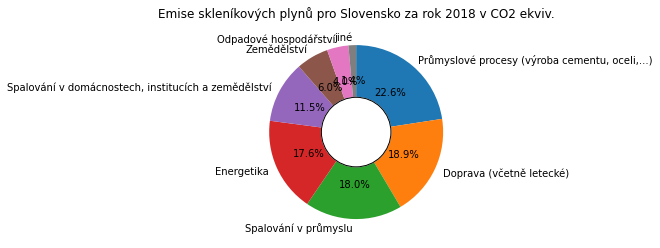

In [1172]:
_, ax = plt.subplots() 
plt.title('Emise skleníkových plynů pro Slovensko za rok 2018 v CO2 ekviv.')
plt.pie(df4[YEAR], labels = label_dict.values(), counterclock=False, startangle=90, autopct='%1.1f%%')
inner_circle_fill = plt.Circle((0, 0), 0.4, color='white') # nastavení vnitřního kruhu
inner_circle_edge = plt.Circle((0, 0), 0.4, color='black', fill=False) # nastavení okraje vnitřního kruhu
ax.add_artist(inner_circle_fill) # "add_artist" vidim prvně
ax.add_artist(inner_circle_edge)
plt.show()
# zatím neumím hejbat s pozicí těch % v grafu. 

# proč ty popisky grafu správně berou "CRF1A3_CRF1D1A" i když ve slovníku je to klíčovaný jinak?
# jak se do toho grafu dostal popisek "jiné" když hodnota pro TOTX4_MEMONIA v tom df není...?
# tohle 'geo\\time' jde řešit nějak líp?
# upravit název grafu tak aby to správně zobrazilo stát a rok 

# !!! přidej do pull requestu: Update requirements.txt - přidat eurostat


Změny:
- přidán slovník s eu kody a popisky a zaintegrován do grafu
- přidány proměné pro rok a stát a zaintegrovány do kodu
- nové řádky s výpočty hodnot přidávány přes df.append()

## Další provozní kusy kodu

In [1173]:
total = df4[YEAR].sum() # sečti sloupec
total

42.32090999999999

In [1174]:
print (df4[YEAR].dtypes) # zjisti datový typ sloupce

float64


In [1175]:
list(df3.columns) # vyjeď názvy sloupců

['src_crf', 2018]

In [1176]:
df.airpol.unique() # ukáže mi co unikátního tam všechno mám 

array(['CH4', 'CH4_CO2E', 'CO2', 'GHG', 'HFC_CO2E', 'HFC_PFC_NSP_CO2E',
       'N2O', 'N2O_CO2E', 'NF3_CO2E', 'PFC_CO2E', 'SF6_CO2E'],
      dtype=object)

## Další tabulka

In [1177]:
df_demo = eurostat.get_data_df('demo_pjan')

In [1178]:
df_demo.head()

,unit,age,sex,geo\time,2021,2020,2019,2018,2017,2016,...,1969,1968,1967,1966,1965,1964,1963,1962,1961,1960
0,NR,TOTAL,F,AD,NaN,NaN,37388.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NR,TOTAL,F,AL,1419759.0,1425342.0,1432833.0,1431715.0,1423050.0,1417141.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NR,TOTAL,F,AM,1565144.0,1562689.0,1563538.0,1564533.0,1567380.0,1569535.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NR,TOTAL,F,AT,4535712.0,4522292.0,4501742.0,4483749.0,4460424.0,4427918.0,...,3932691.0,3922359.0,3899799.0,3876559.0,3857760.0,3836415.0,3814191.0,3794130.0,3773097.0,3757167.0
4,NR,TOTAL,F,AZ,5065288.0,5039100.0,4999053.0,4960058.0,4918771.0,4870002.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
